**Chinese MNIST dataset Link:**
https://www.kaggle.com/datasets/gpreda/chinese-mnist

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/chinese-mnist/data'
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
RANDOM_STATE = 42
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
same = 2

**Load the data**

Let's see first what data files do we have in the root directory.

In [ ]:
os.listdir("/content/drive/MyDrive/chinese-mnist")

['chinese_mnist.csv', 'data']

There is a dataset file and a folder with images.

Let's load the dataset file first.

In [ ]:
data_df=pd.read_csv('/content/drive/MyDrive/chinese-mnist/chinese_mnist.csv')

 let's check the number of columns and rows.

In [ ]:
data_df.shape

(15000, 5)

In [ ]:
data_df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


**Check for missing data**

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(data_df)

,Total,Percent
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


There is no missing (null) data in the dataset. Still it might be that some of the data labels are misspelled; we will check this when we will analyze each data feature.

**Explore image data**

Let's also check the image data. First, we check how many images are stored in the image folder.

In [ ]:
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 15009


In [ ]:
def create_file_name(x):

    file_name = f"/input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

In [ ]:
data_df["file"] = data_df.apply(create_file_name, axis=1)

In [ ]:
file_names = list(data_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 0


In [ ]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

In [ ]:
m = np.stack(data_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h'])
data_df = pd.concat([data_df,df],axis=1, sort=False)

In [ ]:
data_df.head()

,suite_id,sample_id,code,value,character,file,w,h
0,1,1,10,9,九,/input_1_1_10.jpg,64,64
1,1,10,10,9,九,/input_1_10_10.jpg,64,64
2,1,2,10,9,九,/input_1_2_10.jpg,64,64
3,1,3,10,9,九,/input_1_3_10.jpg,64,64
4,1,4,10,9,九,/input_1_4_10.jpg,64,64


**Characters classification**

We have a unique dataset and we will have to split this dataset in train and test. The train set will be used for training a model and the test will be used for testing the model accuracy against new, fresh data, not used in training.

**Split the data**

First, we split the whole dataset in train and test. We will use random_state to ensure reproductibility of results.

The train-test split is 80% for training set and 20% for test set.

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=RANDOM_STATE)

Next, we will split further the train set in train and validation. We want to use as well a validation set to be able to measure not only how well fits the model the train data during training (or how well learns the training data) but also how well the model is able to generalize so that we are able to understands not only the bias but also the variance of the model.

The train-validation split is 80% for training set and 20% for validation set.

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 9600
Test  set rows: 3000
Val   set rows: 2400


In [ ]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center")
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



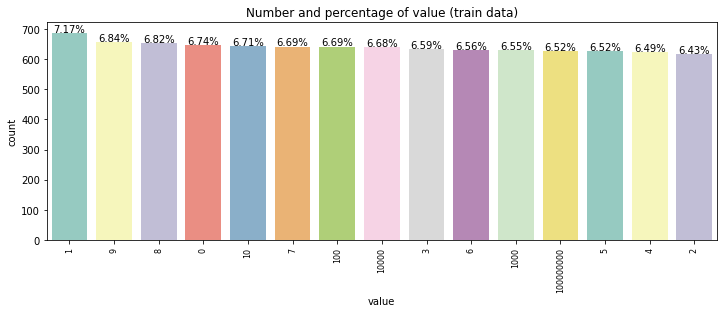

In [ ]:
plot_count("value", "value (train data)", train_df, size=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



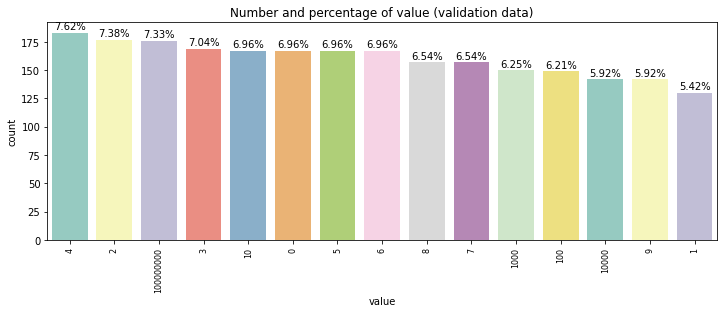

In [ ]:
plot_count("value", "value (validation data)", val_df, size=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



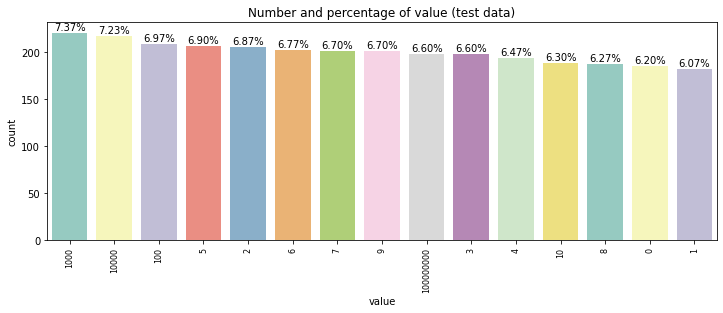

In [ ]:
plot_count("value", "value (test data)", test_df, size=3)

Training, validation and test data are slightly unbalanced. We can improve on this part, if we use a different train-test split approach, imposing to have balanced distribution in the splits, based on the label feature. Let's do it now.

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=RANDOM_STATE, stratify=data_df["code"].values)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE, stratify=train_df["code"].values)
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 9600
Test  set rows: 3000
Val   set rows: 2400


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



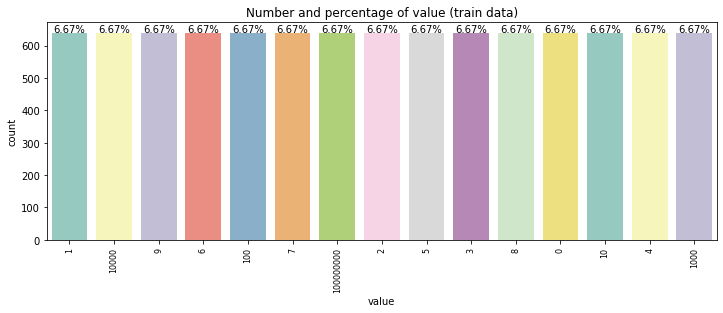

In [ ]:
plot_count("value", "value (train data)", train_df, size=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



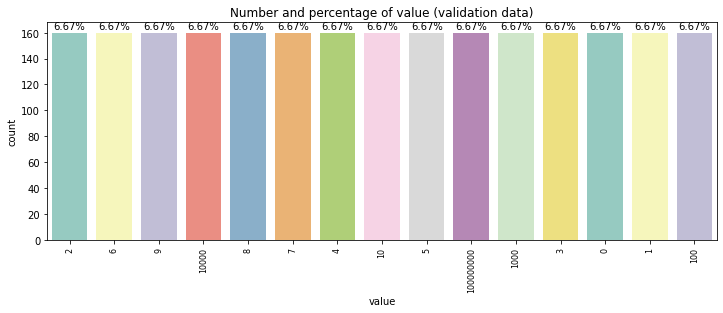

In [ ]:
plot_count("value", "value (validation data)", val_df, size=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



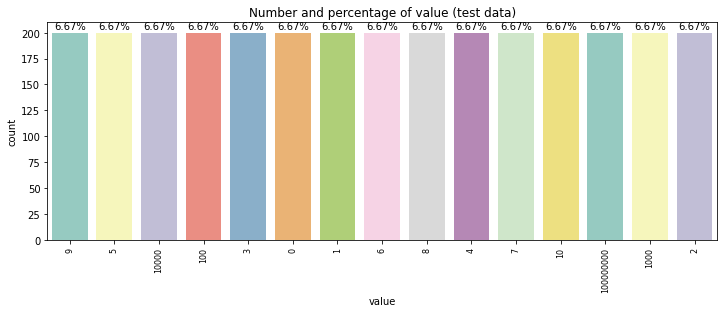

In [ ]:
plot_count("value", "value (test data)", test_df, size=3)

**Build a baseline model**

Next step in our creation of a predictive model is to create a simple model, a baseline model.

Why start with a simple model (as simple as possible, but not simpler :-) )?

With a simple model, we can get fast insight in how well will the data predict our target value. Looking to the training results (the training error and accuracy, the validation error and accuracy), we can understand if we need to add more data (because the training accuracy is small) or if we need to optimize the model (by adding more convolutional layers) or if we need to add Dropout layers (because the validation error is increasing after few steps - the model is overfitting) etc.

Let's define few auxiliary functions that we will need for creation of our models.

In [ ]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT, 1), mode='reflect')
    return image[:,:,:]

In [ ]:
def categories_encoder(dataset, var='character'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [ ]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)


One convolutional layer, with 16 filters of dimmension 3;
One maxpoll2d layer, with reduction factor 2;
One convolutional layer, with 16 filters of dimmension 3;
A flatten layer;
A dense layer;

In [ ]:
model1=Sequential()
model1.add(Conv2D(16, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(16, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 15)                245775    
                                                                 
Total params: 248,255
Trainable params: 248,255
Non-trainable params: 0
________________________________________________

In [ ]:
train_model1 = model1.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=5,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
300/300 [==============================] - 29s 94ms/step - loss: 1.4368 - accuracy: 0.5522 - val_loss: 0.8703 - val_accuracy: 0.7258
Epoch 2/5
300/300 [==============================] - 27s 91ms/step - loss: 0.6631 - accuracy: 0.7934 - val_loss: 0.6088 - val_accuracy: 0.8050
Epoch 3/5
300/300 [==============================] - 28s 92ms/step - loss: 0.4656 - accuracy: 0.8611 - val_loss: 0.4597 - val_accuracy: 0.8537
Epoch 4/5
300/300 [==============================] - 28s 93ms/step - loss: 0.3693 - accuracy: 0.8857 - val_loss: 0.4281 - val_accuracy: 0.8596
Epoch 5/5
300/300 [==============================] - 28s 92ms/step - loss: 0.3156 - accuracy: 0.9020 - val_loss: 0.4529 - val_accuracy: 0.8533


**Model evaluation**

Let's start by plotting the loss error for the train and validation set. We define a function to visualize these values.

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')


In [ ]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4723660945892334
Test accuracy: 0.8556666374206543


In [ ]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns))
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [ ]:
test_accuracy_report(model1)

94/94 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           一       0.89      0.91      0.90       200
           七       0.81      0.78      0.79       200
           万       0.95      0.76      0.84       200
           三       0.83      0.81      0.82       200
           九       0.86      0.85      0.86       200
           二       0.75      0.79      0.77       200
           五       0.89      0.90      0.89       200
           亿       0.92      0.92      0.92       200
           八       0.98      0.97      0.97       200
           六       0.75      0.96      0.84       200
           十       0.98      0.75      0.85       200
           千       0.68      0.93      0.78       200
           四       0.97      0.77      0.85       200
           百       0.80      0.78      0.79       200
           零       0.94      0.96      0.95       200

    accuracy                           0.86      3000
   macro avg       0.87   

Adding additional data will only slightly increase the accuracy of the training set (it is already very good).
To reduce the loss of the validation set (which is a sign of overfitting), we can have three strategies:

add Dropout layers;
introduce strides;
modify the learning rate during the training;

**Add Dropout**

We add two Dropout layers. The role of the Dropout layers is to reduce the overfitting, by dropping, each training epoch, a certain percent of the nodes connections (by rotation). This is equivalent of using less training data and in the same time training the network with various data as well as using parallel alternative networks, thus reducing the likelihood that the network will overfit the train data.

In [ ]:
model2=Sequential()
model2.add(Conv2D(16, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Conv2D(16, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                      

In [ ]:
train_model2  = model2.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=10,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
300/300 [==============================] - 31s 103ms/step - loss: 1.6193 - accuracy: 0.5097 - val_loss: 0.9400 - val_accuracy: 0.7071
Epoch 2/10
300/300 [==============================] - 31s 102ms/step - loss: 0.8212 - accuracy: 0.7450 - val_loss: 0.6763 - val_accuracy: 0.7950
Epoch 3/10
300/300 [==============================] - 31s 102ms/step - loss: 0.6312 - accuracy: 0.7954 - val_loss: 0.5357 - val_accuracy: 0.8379
Epoch 4/10
300/300 [==============================] - 31s 103ms/step - loss: 0.4986 - accuracy: 0.8384 - val_loss: 0.4345 - val_accuracy: 0.8637
Epoch 5/10
300/300 [==============================] - 31s 102ms/step - loss: 0.4256 - accuracy: 0.8589 - val_loss: 0.4020 - val_accuracy: 0.8679
Epoch 6/10
300/300 [==============================] - 31s 103ms/step - loss: 0.3649 - accuracy: 0.8806 - val_loss: 0.3441 - val_accuracy: 0.8938
Epoch 7/10
300/300 [==============================] - 31s 102ms/step - loss: 0.3303 - accuracy: 0.8934 - val_loss: 0.3455 - val_ac

In [ ]:
plot_accuracy_and_loss(train_model2)

In [ ]:
test_accuracy_report(model2)

94/94 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

           一       0.93      0.95      0.94       200
           七       0.93      0.92      0.92       200
           万       0.89      0.94      0.91       200
           三       0.86      0.86      0.86       200
           九       0.84      0.93      0.88       200
           二       0.82      0.86      0.84       200
           五       0.97      0.92      0.94       200
           亿       0.95      0.88      0.91       200
           八       0.99      0.98      0.99       200
           六       0.94      0.94      0.94       200
           十       0.90      0.94      0.92       200
           千       0.92      0.90      0.91       200
           四       0.94      0.92      0.93       200
           百       0.92      0.86      0.89       200
           零       0.98      0.98      0.98       200

    accuracy                           0.92      3000
   macro avg       0.92   

In [ ]:
annealer3 = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+50))
earlystopper3 = EarlyStopping(monitor='loss', patience=5, verbose=1)
checkpointer3 = ModelCheckpoint('best_model_3.h5',
                                monitor='val_acc',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

In [ ]:
model3=Sequential()
model3.add(Conv2D(16, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model3.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Conv2D(16, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(y_train.columns.size, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 flatten_5 (Flatten)         (None, 16384)             0         
                                                      

In [ ]:
train_model3  = model3.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=50,
                  verbose=1,
                  validation_data=(X_val, y_val),
                  callbacks=[earlystopper3, checkpointer3, annealer3])

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 1.7730 - accuracy: 0.4581

300/300 [==============================] - 32s 105ms/step - loss: 1.7730 - accuracy: 0.4581 - val_loss: 1.3548 - val_accuracy: 0.5921 - lr: 7.7831e-04
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 1.0191 - accuracy: 0.6885

300/300 [==============================] - 31s 103ms/step - loss: 1.0191 - accuracy: 0.6885 - val_loss: 0.8010 - val_accuracy: 0.7596 - lr: 7.7442e-04
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.7608

300/300 [==============================] - 30s 101ms/step - loss: 0.7649 - accuracy: 0.7608 - val_loss: 0.7103 - val_accuracy: 0.7650 - lr: 7.7055e-04
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7891

300/300 [==============================] - 30s 101ms/step - loss: 0.6493 - accuracy: 0.7891 - val_loss: 0.6305 - val_accuracy: 0.7954 - lr: 7.6670e-04
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.8089

300/300 [==============================] - 31s 102ms/step - loss: 0.5860 - accuracy: 0.8089 - val_loss: 0.5543 - val_accuracy: 0.8229 - lr: 7.6286e-04
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.8234

300/300 [==============================] - 31s 102ms/step - loss: 0.5411 - accuracy: 0.8234 - val_loss: 0.5014 - val_accuracy: 0.8417 - lr: 7.5905e-04
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8397

300/300 [==============================] - 31s 104ms/step - loss: 0.4778 - accuracy: 0.8397 - val_loss: 0.4953 - val_accuracy: 0.8417 - lr: 7.5525e-04
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8550

300/300 [==============================] - 31s 103ms/step - loss: 0.4370 - accuracy: 0.8550 - val_loss: 0.4442 - val_accuracy: 0.8571 - lr: 7.5148e-04
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8680

300/300 [==============================] - 30s 101ms/step - loss: 0.3934 - accuracy: 0.8680 - val_loss: 0.4097 - val_accuracy: 0.8712 - lr: 7.4772e-04
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8811

300/300 [==============================] - 31s 102ms/step - loss: 0.3527 - accuracy: 0.8811 - val_loss: 0.3619 - val_accuracy: 0.8938 - lr: 7.4398e-04
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8944

300/300 [==============================] - 30s 101ms/step - loss: 0.3206 - accuracy: 0.8944 - val_loss: 0.3570 - val_accuracy: 0.8888 - lr: 7.4026e-04
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.9018

300/300 [==============================] - 30s 100ms/step - loss: 0.2988 - accuracy: 0.9018 - val_loss: 0.3326 - val_accuracy: 0.9025 - lr: 7.3656e-04
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9049

300/300 [==============================] - 30s 100ms/step - loss: 0.2807 - accuracy: 0.9049 - val_loss: 0.3550 - val_accuracy: 0.8946 - lr: 7.3288e-04
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9098

300/300 [==============================] - 31s 102ms/step - loss: 0.2692 - accuracy: 0.9098 - val_loss: 0.3248 - val_accuracy: 0.9008 - lr: 7.2921e-04
Epoch 15/50
300/300 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9184

300/300 [==============================] - 31s 104ms/step - loss: 0.2502 - accuracy: 0.9184 - val_loss: 0.3192 - val_accuracy: 0.9104 - lr: 7.2557e-04
Epoch 16/50
300/300 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9144

300/300 [==============================] - 30s 101ms/step - loss: 0.2496 - accuracy: 0.9144 - val_loss: 0.3170 - val_accuracy: 0.9046 - lr: 7.2194e-04
Epoch 17/50
300/300 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9270

300/300 [==============================] - 31s 102ms/step - loss: 0.2235 - accuracy: 0.9270 - val_loss: 0.3021 - val_accuracy: 0.9142 - lr: 7.1833e-04
Epoch 18/50
300/300 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9237

300/300 [==============================] - 31s 104ms/step - loss: 0.2198 - accuracy: 0.9237 - val_loss: 0.2819 - val_accuracy: 0.9221 - lr: 7.1474e-04
Epoch 19/50
300/300 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9293

300/300 [==============================] - 31s 104ms/step - loss: 0.2113 - accuracy: 0.9293 - val_loss: 0.3128 - val_accuracy: 0.9075 - lr: 7.1116e-04
Epoch 20/50
300/300 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9271

300/300 [==============================] - 31s 104ms/step - loss: 0.2076 - accuracy: 0.9271 - val_loss: 0.3012 - val_accuracy: 0.9104 - lr: 7.0761e-04
Epoch 21/50
300/300 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9346

300/300 [==============================] - 31s 104ms/step - loss: 0.1935 - accuracy: 0.9346 - val_loss: 0.2853 - val_accuracy: 0.9258 - lr: 7.0407e-04
Epoch 22/50
300/300 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9388

300/300 [==============================] - 31s 104ms/step - loss: 0.1810 - accuracy: 0.9388 - val_loss: 0.2957 - val_accuracy: 0.9192 - lr: 7.0055e-04
Epoch 23/50
300/300 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9403

300/300 [==============================] - 31s 105ms/step - loss: 0.1754 - accuracy: 0.9403 - val_loss: 0.2690 - val_accuracy: 0.9275 - lr: 6.9705e-04
Epoch 24/50
300/300 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9385

300/300 [==============================] - 31s 104ms/step - loss: 0.1716 - accuracy: 0.9385 - val_loss: 0.2749 - val_accuracy: 0.9254 - lr: 6.9356e-04
Epoch 25/50
300/300 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9423

300/300 [==============================] - 31s 104ms/step - loss: 0.1690 - accuracy: 0.9423 - val_loss: 0.2907 - val_accuracy: 0.9254 - lr: 6.9009e-04
Epoch 26/50
300/300 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9475

300/300 [==============================] - 31s 104ms/step - loss: 0.1536 - accuracy: 0.9475 - val_loss: 0.2683 - val_accuracy: 0.9296 - lr: 6.8664e-04
Epoch 27/50
300/300 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9449

300/300 [==============================] - 31s 104ms/step - loss: 0.1539 - accuracy: 0.9449 - val_loss: 0.2845 - val_accuracy: 0.9267 - lr: 6.8321e-04
Epoch 28/50
300/300 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9464

300/300 [==============================] - 31s 103ms/step - loss: 0.1519 - accuracy: 0.9464 - val_loss: 0.2559 - val_accuracy: 0.9342 - lr: 6.7979e-04
Epoch 29/50
300/300 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9507

300/300 [==============================] - 31s 103ms/step - loss: 0.1457 - accuracy: 0.9507 - val_loss: 0.2688 - val_accuracy: 0.9292 - lr: 6.7639e-04
Epoch 30/50
300/300 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9525

300/300 [==============================] - 31s 103ms/step - loss: 0.1474 - accuracy: 0.9525 - val_loss: 0.2626 - val_accuracy: 0.9325 - lr: 6.7301e-04
Epoch 31/50
300/300 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9538

300/300 [==============================] - 31s 102ms/step - loss: 0.1333 - accuracy: 0.9538 - val_loss: 0.2539 - val_accuracy: 0.9337 - lr: 6.6965e-04
Epoch 32/50
300/300 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9525

300/300 [==============================] - 31s 103ms/step - loss: 0.1374 - accuracy: 0.9525 - val_loss: 0.2688 - val_accuracy: 0.9367 - lr: 6.6630e-04
Epoch 33/50
300/300 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9553

300/300 [==============================] - 31s 103ms/step - loss: 0.1234 - accuracy: 0.9553 - val_loss: 0.2600 - val_accuracy: 0.9358 - lr: 6.6297e-04
Epoch 34/50
300/300 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9531

300/300 [==============================] - 31s 103ms/step - loss: 0.1319 - accuracy: 0.9531 - val_loss: 0.2659 - val_accuracy: 0.9279 - lr: 6.5965e-04
Epoch 35/50
300/300 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9568

300/300 [==============================] - 31s 103ms/step - loss: 0.1253 - accuracy: 0.9568 - val_loss: 0.2671 - val_accuracy: 0.9329 - lr: 6.5635e-04
Epoch 36/50
300/300 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9548

300/300 [==============================] - 31s 104ms/step - loss: 0.1290 - accuracy: 0.9548 - val_loss: 0.2564 - val_accuracy: 0.9346 - lr: 6.5307e-04
Epoch 37/50
300/300 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9570

300/300 [==============================] - 31s 104ms/step - loss: 0.1236 - accuracy: 0.9570 - val_loss: 0.2585 - val_accuracy: 0.9367 - lr: 6.4981e-04
Epoch 38/50
300/300 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9635

300/300 [==============================] - 31s 103ms/step - loss: 0.1096 - accuracy: 0.9635 - val_loss: 0.2438 - val_accuracy: 0.9371 - lr: 6.4656e-04
Epoch 39/50
300/300 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9627

300/300 [==============================] - 31s 103ms/step - loss: 0.1105 - accuracy: 0.9627 - val_loss: 0.2547 - val_accuracy: 0.9388 - lr: 6.4333e-04
Epoch 40/50
300/300 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9648

300/300 [==============================] - 31s 104ms/step - loss: 0.1073 - accuracy: 0.9648 - val_loss: 0.2578 - val_accuracy: 0.9312 - lr: 6.4011e-04
Epoch 41/50
300/300 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9620

300/300 [==============================] - 31s 104ms/step - loss: 0.1072 - accuracy: 0.9620 - val_loss: 0.2541 - val_accuracy: 0.9400 - lr: 6.3691e-04
Epoch 42/50
300/300 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9598

300/300 [==============================] - 31s 104ms/step - loss: 0.1086 - accuracy: 0.9598 - val_loss: 0.2436 - val_accuracy: 0.9425 - lr: 6.3372e-04
Epoch 43/50
300/300 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9664

300/300 [==============================] - 31s 104ms/step - loss: 0.1011 - accuracy: 0.9664 - val_loss: 0.2551 - val_accuracy: 0.9396 - lr: 6.3056e-04
Epoch 44/50
300/300 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9643

300/300 [==============================] - 31s 103ms/step - loss: 0.0998 - accuracy: 0.9643 - val_loss: 0.2610 - val_accuracy: 0.9408 - lr: 6.2740e-04
Epoch 45/50
300/300 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9644

300/300 [==============================] - 31s 104ms/step - loss: 0.0989 - accuracy: 0.9644 - val_loss: 0.2410 - val_accuracy: 0.9442 - lr: 6.2427e-04
Epoch 46/50
300/300 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9651

300/300 [==============================] - 32s 106ms/step - loss: 0.0988 - accuracy: 0.9651 - val_loss: 0.2490 - val_accuracy: 0.9421 - lr: 6.2114e-04
Epoch 47/50
300/300 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9651

300/300 [==============================] - 32s 107ms/step - loss: 0.0954 - accuracy: 0.9651 - val_loss: 0.2483 - val_accuracy: 0.9417 - lr: 6.1804e-04
Epoch 48/50
300/300 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9652

300/300 [==============================] - 32s 107ms/step - loss: 0.0963 - accuracy: 0.9652 - val_loss: 0.2737 - val_accuracy: 0.9358 - lr: 6.1495e-04
Epoch 49/50
300/300 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9686

300/300 [==============================] - 32s 107ms/step - loss: 0.0863 - accuracy: 0.9686 - val_loss: 0.2534 - val_accuracy: 0.9450 - lr: 6.1187e-04
Epoch 50/50
300/300 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9682

300/300 [==============================] - 32s 107ms/step - loss: 0.0944 - accuracy: 0.9682 - val_loss: 0.2606 - val_accuracy: 0.9371 - lr: 6.0881e-04


In [ ]:
plot_accuracy_and_loss(train_model3)

In [ ]:
test_accuracy_report(model3)

94/94 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           一       0.90      0.97      0.94       200
           七       0.91      0.96      0.93       200
           万       0.97      0.93      0.95       200
           三       0.90      0.89      0.89       200
           九       0.92      0.89      0.90       200
           二       0.86      0.82      0.84       200
           五       0.97      0.95      0.96       200
           亿       0.94      0.94      0.94       200
           八       0.98      0.99      0.99       200
           六       0.99      0.98      0.99       200
           十       0.88      0.96      0.92       200
           千       0.96      0.88      0.92       200
           四       0.96      0.94      0.95       200
           百       0.89      0.94      0.92       200
           零       0.99      0.99      0.99       200

    accuracy                           0.94      3000
   macro avg       0.94   

**Conclusions**

After exploring the data to understand its various features, a baseline model is created. We start with a baseline model because we want to evaluate first how a simple model performs, what is the precision/accuracy for training, validation and test set.

Evaluation of the baseline model results for valid set and test set allows us to decide, based on analysis of bias and variance, how to conduct furher our experiments. After the analysis of the baseline solution, we decided that, while the training is good enough, we would like to improve on the variance, thus reducing overfitting.

From the possible solutions for overfitting, we choose to add Dropout layers. Adding Dropout layers improve a bit the algorithm performance (reduce overfitting).

A third model, with adjustable learning rate, early stoping based on validation accuracy measurement. The model is saved every time when validation accuracy improves. Also, the training will stop if after a number of steps the validation accuracy is not improving. With this model, accuracy of prediction for the test set was improved. But looking to the validation loss, we can see we do have a problem - we most probably we still overfit on train data, so we will have to further improve this model.

The key lessons learned from this Kernel are the following:

start by analyzing the data;
follow with a simple baseline model;
refine gradually the model, by making corrections based on the analysis of the (partial) results.